In [2]:
from google.colab import files
uploaded = files.upload()  # choose winequality-red.csv when prompted


Saving winequality-red.csv to winequality-red.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (change filename/path if needed)
df = pd.read_csv("winequality-red.csv")

# Quick check
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Shape & Columns
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)




Shape: (1599, 12)

Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Data Types:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [5]:
# Missing values
print("\nMissing values per column:\n", df.isnull().sum())




Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [6]:
# Summary statistics
print("\nSummary statistics:\n", df.describe().T)




Summary statistics:
                        count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
pH                    1599.0   3.311113   0.154386  2.74000   3.2100   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   

                           50%        75%

/tmp/ipython-input-2942888038.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


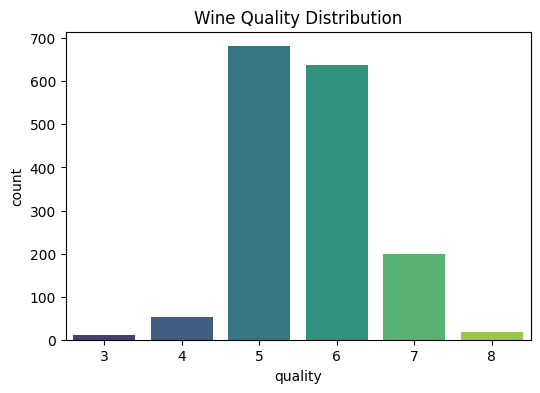

In [7]:
# Quality distribution
plt.figure(figsize=(6,4))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Wine Quality Distribution')
plt.show()



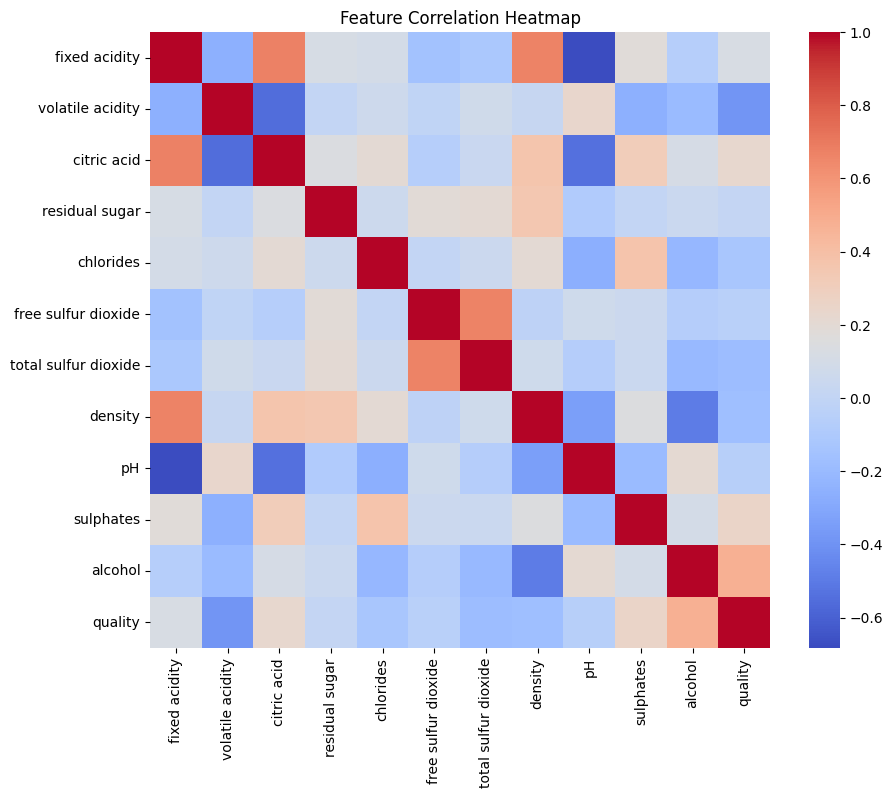

In [8]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Create binary target
df['target_good'] = (df['quality'] >= 7).astype(int)

# 2. Features and target
X = df.drop(columns=['quality', 'target_good'])
y = df['target_good']

# 3. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1279, 11)
Test shape: (320, 11)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pipelines (so we don’t worry about manual scaling later)
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, class_weight='balanced'
    ))
])

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

models = {
    'LogReg': lr_pipe,
    'RandomForest': rf_pipe,
    'SVM': svm_pipe
}


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, model in models.items():
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    rows.append([name, f1.mean(), f1.std(), auc.mean(), auc.std()])

cv_results = pd.DataFrame(rows, columns=['model','f1_mean','f1_std','auc_mean','auc_std'])
cv_results.sort_values(by='auc_mean', ascending=False, inplace=True)
cv_results


,model,f1_mean,f1_std,auc_mean,auc_std
1,RandomForest,0.611892,0.053042,0.918504,0.021461
2,SVM,0.529094,0.022176,0.887153,0.026102
0,LogReg,0.511730,0.021852,0.876909,0.022233


In [12]:
best_name = cv_results.iloc[0]['model']
best_model = models[best_name]
print(f"Best by AUC: {best_name}")

best_model.fit(X_train, y_train)


Best by AUC: RandomForest


Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [13]:
# --- save CV results + chosen model name for the app ---
from pathlib import Path
import json

ART_DIR = Path("artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save CV table
cv_results.to_csv(ART_DIR / "cv_results.csv", index=False)

# 2) Save metadata (best model name, metric used)
meta = {
    "selection_metric": "auc_mean",
    "best_model_name": best_name,
    "created_from": "cross_val",
}
with open(ART_DIR / "model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)



In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

y_prob = best_model.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))




Accuracy: 0.946875
F1: 0.7605633802816901
ROC-AUC: 0.937956510788347

Classification report:
               precision    recall  f1-score   support

           0      0.945     0.996     0.970       277
           1      0.964     0.628     0.761        43

    accuracy                          0.947       320
   macro avg      0.955     0.812     0.865       320
weighted avg      0.948     0.947     0.942       320



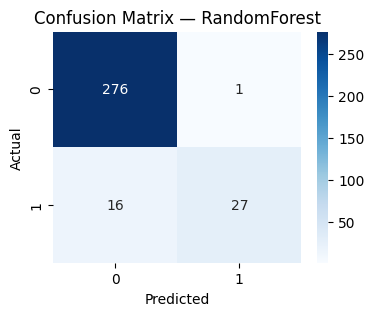

In [15]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix — {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()


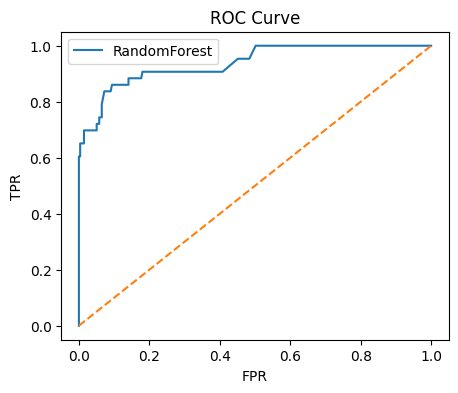

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'{best_name}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.show()

In [17]:
import joblib
joblib.dump(best_model, 'model.pkl')
feature_order = X.columns.tolist()
joblib.dump(feature_order, 'feature_order.pkl')
print("Saved: model.pkl & feature_order.pkl")


Saved: model.pkl & feature_order.pkl


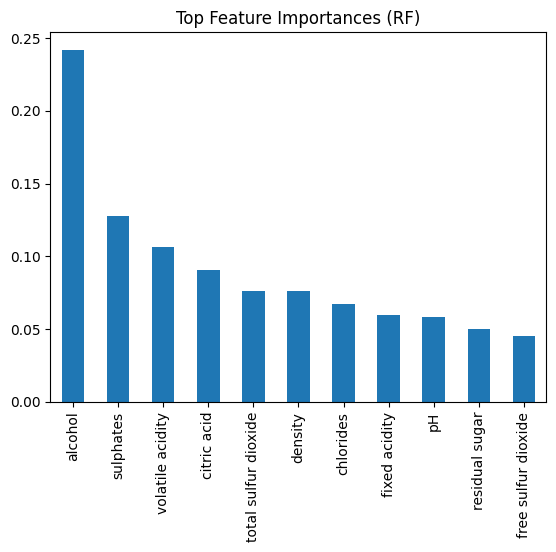

In [18]:
if best_name == 'RandomForest':
    importances = best_model.named_steps['clf'].feature_importances_
    imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    imp.head(15).plot(kind='bar')
    plt.title('Top Feature Importances (RF)')
    plt.show()
